In [229]:
import math as m
import numpy as np
import random as rnd

class organismObject:
    '''This is a basic organism object. Has nutrients, sugar, and connections.'''
    def __init__(self, n = 0, s = 0,u =1):
        self.nutrients = n
        self.sugar = s
        self.connections = set()
        self.uptakeCoeff = u
        
#         #print("Nutrient: " + str(self.nutrients) 
#               + "; sugar: " + str(self.sugar)
#              + "; connections: " + str(self.connections))
        
    # set attribute methods
    def set_nutrients(self,newNutrients = 0): 
        self.nutrients = newNutrients
        
    def set_sugar(self,newSugar = 0):
        self.sugar = newSugar
    
    def add_connection(self,newConnection):
        self.connections.add(newConnection)
        
    def remove_connection(self,oldConnection):
        self.connections.discard(oldConnection)
        
    # get attribute methods
    def get_nutrients(self): n = self.nutrients; return n
    def get_sugar(self): s = self.sugar; return s
    def get_connections(self): c = self.connections; return c
    
    # probability methods
    def get_uptake_Prob(self,N):
        return N*self.uptakeCoeff
    

            

# end organismObject


class plantObject(organismObject):
    '''This is a new plant object. An organism with a growth attribute and alive status.'''
    
    def __init__(self,g = 0.1, n = 0, s = 0,u = 1, sf = 5):
        organismObject.__init__(self,n,s,u)
        self.growth = g
        self.alive = True
        self.RxnList = [-1,-1,-1,-1,-1,-1]
        self.sugarFrac = sf
        
    # set attribute methods
    def set_growth(self,newGrowth = 0): 
        self.growth = newGrowth
    def set_alive(self,alive = True):
        self.alive = alive
    def set_Rxn_loc(self,rxn,loc):
        self.RxnList[rxn] = loc
        
    # get attribute methods
    def get_growth(self): g = self.growth; return g
    def get_life(self): a = self.alive; return a
    def get_RxnList(self): rl = self.RxnList; return rl
    def get_type(self): return "plant"
    def get_MaxSugar(self): ms = self.growth*self.sugarFrac; return ms
    
    
    # Probability methods
    def get_exchange_Prob(self,fungi):
        if len(self.connections) > 0:
            prob = 0
            for i in range(len(self.connections)):
                prob +=  fungi[i].get_nutrients()+self.sugar
        else: prob = 0
        return prob
        
    def get_uptake_Prob(self,N):
        prob = N*self.uptakeCoeff*self.growth)
        return prob
    
    def get_produce_sugar_Prob(self,ph):
        return ph*self.nutrients*self.growth
    
    def get_grow_Prob(self):
        return self.nutrients*self.sugar#/self.get_MaxSugar()
    
    def get_spawn_Prob(self,r):
        return r*self.growth
    
    def get_maint_Prob(self,c):
        prob = self.growth*c/(self.nutrients+1)
        return prob

# End class plantObject


class fungusObject(organismObject):
    '''This is a new fungus object. An organism with an active status.'''
    def __init__(self,n = 0, s = 0,u = 1,nf = 5):
        organismObject.__init__(self,n,s,u)
        self.active = True
        self.RxnList =  [-1,-1,-1,-1,-1,-1,-1,-1]
        self.nutrientFrac = nf
        
    # set attribute methods
    def set_active(self,active = True):
        self.active = active
    def set_Rxn_loc(self,rxn,loc):
        self.RxnList[rxn] = loc
        
    # get attribute methods
    def get_active(self): a = self.active; return a
    def get_RxnList(self): rl = self.RxnList; return rl
    def get_type(self): return "fungus"
    def get_MaxNutrients(self): mn = len(self.get_connections())*self.nutrientFrac; return mn
    
    # Probability methods
    def get_exchange_Prob(self,plants):
        prob = 0
        if len(self.connections) > 0:
            for i in range(len(self.connections)):
                prob +=  plants[i].get_sugar()+(self.nutrients)
        
        return prob
    
    def get_connect_Prob(self,numLivePlants):
        return (self.nutrients*numLivePlants)
    
    def get_dormant_Prob(self):
        return 10/self.sugar
    
    def get_spawn_Prob(self,R):
        return R*self.nutrients*self.sugar
    
        
# End class fungusObject

# This one is a monster.
class ecoPatch:
    ''' An eco patch. Should update probabilities. So should maintain list order.'''
    def __init__(self,
               numPlants = 2,startPS=2, startPN=1, pU=.2, 
               numFungi = 2,startFS=1,startFN=1,fU=10,
               environmentalN=1000,maintCost=.5,t=0):
        self.N = environmentalN
        self.nP = 0; self.nPlive = 0
        self.nF = 0; self.nFlive = 0
        self.startPs = startPS; self.startPn = startPN; self.pu = pU
        self.startFs = startFS; self.startFn = startFN; self.fu = fU
        self.orgs = []
        self.tree = []
        self.liveIndex = []
        self.treeSize = -1
        self.time = t
        self.c = maintCost
        self.newLeafParent = None
        self.currentTreeTop = -1
        self.last_rxn = -1; self.last_rxn_org = "none";
        self.last_rxn_prob = -1; self.last_rxn_org_num = -1;
        print("Actually ran and updated. After fixing R and P")    
        for i in range(numPlants):
            self.add_Plant(startPS,startPN,pU)
        print("~~~~~"+str(self.nP)+" PLANTS ADDED~~~~~~~~~~"); self.print_RxnTree
        for i in range(numFungi):
            self.add_Fungus(startPS,startPN,fU)
        print("~~~~~"+str(self.nF)+ "FUNGI ADDED~~~~~~~~~~"); self.print_RxnTree
            
    # environmental factors
    # reproductive
#     def R(self):
#         r = max(m.sin(self.time/365),0)
#         return r
#     # photosynthesis
#     def P(self):
#         param = np.mod(self.time/2,2)-1
#         p = abs(m.sin(param)) + np.random.uniform()
#         return p
    def R(self):
        r = max(m.sin(self.time*6/365),0)
        return r
    # photosynthesis
    def P(self):
        first = m.sin(self.time*4/365)
        p = abs(first) + np.random.uniform()/4
        return p/4000
    
    # interactive methods ---------------------------------------------
    def next_Rxn(self):
        organism = self.tree[self.currentTreeTop][1][2]
        rxn = self.tree[self.currentTreeTop][1][3]
        self.time = self.tree[self.currentTreeTop][1][0]
        self.last_rxn = rxn 
        self.last_rxn_org = self.orgs[organism].get_type()
        self.last_rxn_prob = self.tree[self.currentTreeTop][1][1]  
        self.last_rxn_org_num = organism
        
        if self.orgs[organism].get_type() == "plant":
            if rxn == 0:
                self.run_exchange_plant(organism)
                self.last_rxn_type = "Exchange"
            elif rxn == 1:
                self.run_uptake_plant(organism)
                self.last_rxn_type = "Uptake"
            elif rxn == 2:
                self.run_spawn_plant(organism)
                self.last_rxn_type = "Spawn"
            elif rxn == 3:
                self.run_maint_plant(organism)
                self.last_rxn_type = "Maint"
            elif rxn == 4:
                self.run_grow_plant(organism)
                self.last_rxn_type = "Grow"
            elif rxn == 5:
                self.run_produce_sugar_plant(organism)
                self.last_rxn_type = "Photo"
        else:
            if rxn == 0:
                self.run_exchange_fungus(organism)
                self.last_rxn_type = "Exchange"
            elif rxn == 1:
                self.run_uptake_fungus(organism)
                self.last_rxn_type = "Uptake"
            elif rxn == 2:
                self.run_spawn_fungus(organism)
                self.last_rxn_type = "Spawn"
            elif rxn == 6:
                self.run_go_dormant_fungus(organism)
                self.last_rxn_type = "Dormant"
            elif rxn == 7:
                self.run_connect_fungus(organism)
                self.last_rxn_type = "Connect"
    # end function next_Rxn(self)
    
    # reports

    def get_nP(self): n = self.nP; return n
    def get_nF(self): n = self.nF; return n
    def get_nP_live(self): n = self.nPlive; return n
    def get_nF_live(self): n = self.nFlive; return n
    def get_orgs(self,index): o = self.orgs[index]; return o
    def get_orgs_plants(self): o = self.orgs[0:nP]; return o
    def get_orgs_fungi(self): o = self.orgs[nP:]; return o
    def get_orgs_all(self): o = self.orgs; return o
    def get_environmental_nutrients(self): n = self.N; return n
    def get_time(self): t = self.time; return t
    def get_last_rxn(self): r = self.last_rxn; t = self.last_rxn_org; p = self.last_rxn_prob; return (r,t,p)
    def get_tree_size(self): s = self.treeSize; return s
    def get_life_status(self): li = self.liveIndex; return li
    
    
    
    # utilities
    # adding/killing methods--------------------------------------------
    def add_Plant(self,s,n,u):
        self.nP += 1
        self.nPlive += 1
        iP = self.nP-1
        self.orgs.insert(self.nP,plantObject(g = 0.05,n = n, s = s,u = u))
        self.liveIndex.insert(self.nP,1)
        # A new thingy can't exchange
        p = 0; tau = float("inf")
        self.orgs[iP].set_Rxn_loc(0,self.add_leaf(p, tau,iP,0))
        # uptake time
        p = self.orgs[iP].get_uptake_Prob(self.N); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iP].set_Rxn_loc(1,self.add_leaf(p, tau,iP,1))
        self.tree_reorg(self.orgs[iP].get_RxnList()[1])
        # spawn time
        p = self.orgs[iP].get_spawn_Prob(self.R()); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iP].set_Rxn_loc(2,self.add_leaf(p,tau,iP,2))
        self.tree_reorg(self.orgs[iP].get_RxnList()[2])
        # maintenance time
        p = self.orgs[iP].get_maint_Prob(self.c); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iP].set_Rxn_loc(3,self.add_leaf(p,tau,iP,3))
        self.tree_reorg(self.orgs[iP].get_RxnList()[3])
        # grow time
        p = self.orgs[iP].get_grow_Prob();
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iP].set_Rxn_loc(4,self.add_leaf(p,tau,iP,4))
        self.tree_reorg(self.orgs[iP].get_RxnList()[4])
        # produce sugar time
        p = self.orgs[iP].get_produce_sugar_Prob(self.P()); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iP].set_Rxn_loc(5,self.add_leaf(p,tau,iP,5))
        self.tree_reorg(self.orgs[iP].get_RxnList()[5])
     # end function add_plant(self,s,n,u)   
        
    def add_Fungus(self,s,n,u):
        self.nF += 1
        self.nFlive += 1
        iF = self.nP + self.nF -1
        self.orgs.append(fungusObject(n = n, s = s, u = u))
        self.liveIndex.append(1)
        # New thing can't exchange bc has no connections
        p = 0; tau = float("inf")
        self.orgs[iF].set_Rxn_loc(0,self.add_leaf(p,tau,iF,0))
        self.tree_reorg(self.orgs[iF].get_RxnList()[0])
        # uptake time
        p = self.orgs[iF].get_uptake_Prob(self.N); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iF].set_Rxn_loc(1,self.add_leaf(p,tau,iF,1))
        self.tree_reorg(self.orgs[iF].get_RxnList()[1])
        # spawn time
        p = self.orgs[iF].get_spawn_Prob(self.R()); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iF].set_Rxn_loc(2,self.add_leaf(p,tau,iF,2))
        self.tree_reorg(self.orgs[iF].get_RxnList()[2])
        # dormancy time
        p = self.orgs[iF].get_dormant_Prob(); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iF].set_Rxn_loc(6,self.add_leaf(p,tau,iF,6))
        self.tree_reorg(self.orgs[iF].get_RxnList()[6])
        # connect time
        p = self.orgs[iF].get_connect_Prob(self.nP); 
        if p == 0:tau = float('inf')
        else: tau = np.random.exponential(p)
        self.orgs[iF].set_Rxn_loc(7,self.add_leaf(p,tau,iF,7))
        self.tree_reorg(self.orgs[iF].get_RxnList()[7])
    # end function add_Fungus(self,s,n,u)
        
    def set_loc(self):
        loc = []
        i = 1
        numPods = self.treeSize
      #  print("Finding locString for numPods " + str(numPods))
        while numPods > 0:

            if np.mod(numPods,2**i) == 0:
                loc.append(2)
                numPods -= 2**i
                #print("Even! new numPods = " + str(numPods))
            else:
                loc.append(1)
                numPods -= 2**(i-1)
                #print("Odd! new numPods = " + str(numPods))
            i += 1

        return loc
    
    def get_newLeafParent(self,locs):
        current = self.currentTreeTop
      #  print("Current treeTop: " + str(self.currentTreeTop))
      #  print("address of next: " + str(locs))
        while len(locs)>0:
            nextI = self.tree[current][0][locs[-1]]
            #print("NextI: " + str(nextI))
            if nextI == None:
                break
            else:
                current = nextI
            locs.pop()
        
        return current
    
    def add_leaf(self,p,tau,ecoIndex,rxnType):

        self.treeSize += 1
        if self.treeSize == 0:
            self.newLeafParent = None
            self.currentTreeTop = 0
        else:
            self.newLeafParent = self.get_newLeafParent(self.set_loc())
        parent = self.newLeafParent;             
        child = None
        newEntry = [[parent,child,child],[tau,p,ecoIndex,rxnType]]
        self.tree.append(newEntry)
        # if we're not the first entry
        if not parent == None:
            #print(self.tree[parent])
            if self.tree[parent][0][1] == None:
                self.tree[parent][0][1] = self.treeSize
            else:
                self.tree[parent][0][2] = self.treeSize
            

            
       # print("after add leaf treesize:" + str(self.treeSize))
       # print(self.tree)
        return self.treeSize
    # end function add_leaf(self,p,tau,ecoIndex,rxnType)
    
    def kill_plant(self,organism):
        #print("Before death: "); self.print_RxnTree()
        rxnList = self.orgs[organism].get_RxnList()
        self.nPlive -=1
        self.liveIndex[organism] = 0
        # update connected fungus time
        fungusList = list(self.orgs[organism].get_connections())
        if len(fungusList) > 0:
            for i in fungusList:
                self.orgs[i].remove_connection(organism)
                plantList = self.orgs[i].get_connections()
                p = self.orgs[i].get_exchange_Prob(self.connects(plantList))
                self.update_time(p,self.orgs[i].get_RxnList()[0])
                self.orgs[organism].remove_connection(i)
        
        rxnList = self.orgs[organism].get_RxnList()
        # update self rxn time
        p = 0
        
        for i in range(6):
            if rxnList[i] > -1:
                self.update_time(p,rxnList[i])
        
        
        self.orgs[organism].set_alive(False)
        
       # print("After death: "); self.print_RxnTree()
    # end function kill_plant(self,organism)

    
    # updating methods---------------------------------------------
    def update_time_proper(self,newP,index):
        if newP == 0: newP = float('inf'); newTau = float('inf')
        else:
            newP = 1/newP

            newTau = np.random.exponential(1/newP) + self.time
            timer = 10
            while not m.isnan(newTau) and timer > 0:
                newTau = np.random.exponential(1/newP) + self.time
                timer -= 1
        if m.isnan(newTau):print("Not a number!")
        self.tree[index][1][0] = newTau
        self.tree[index][1][1] = newP
        self.tree_reorg(index)
        
    def update_time(self,newP,index):
        if newP == 0: newP = float('inf'); newTau = float('inf')
        else:
            newP = 1/newP

            oldTau = self.tree[index][1][0]; oldP = self.tree[index][1][1]
            newTau = (oldP/newP)*(oldTau- self.time) + self.time
        self.tree[index][1][0] = newTau
        self.tree[index][1][1] = newP
        self.tree_reorg(index)
        
    def tree_reorg(self,index):
        # the time of rxn [index] has just changed.
        # Do we need to move it up or down the tree?
        parentIndex = self.tree[index][0][0]
        
        # Am I smaller than my parent?
        if not parentIndex  == None:
            if self.tree[index][1][0] < self.tree[parentIndex][1][0]:
                #print("Swapping " + str(index) + ", " + str(parentIndex))
                self.swap_leaf(index,parentIndex)
                #print("Calling recursive tree-reorg on new parent " + str(index))
                self.tree_reorg(index)
                
        # Am I larger than my child?
        childIndex1 = self.tree[index][0][1]
        if not childIndex1 == None:
            if self.tree[childIndex1][1][0] < self.tree[index][1][0]:
               # print("Swapping " + str(index) + ", " + str(childIndex1))
                self.swap_leaf(childIndex1,index)
               # print("Calling recursive tree-reorg on new child " + str(index))
                self.tree_reorg(index)
                self.tree_reorg(childIndex1)
            else:
                childIndex2 = self.tree[index][0][2]
                if not childIndex2 == None:
                    if self.tree[childIndex2][1][0] < self.tree[index][1][0]:
                       # print("Swapping " + str(index) + ", " + str(childIndex2))
                        self.swap_leaf(childIndex2, index)
                       # print("Calling recursive tree-reorg on new child " + str(index))
                        self.tree_reorg(index)
                        self.tree_reorg(childIndex2)
                    
    # end function tree_reorg(self,index)

                

    # end function swap_leaf(self,oldC,oldP)
               
        
    def connects(self,thisList):
        nrg = []
        for i in thisList:
            nrg.append(self.orgs[i])
        return nrg
    # run reactions methods------------------------------------------------
    def run_exchange_plant(self,organism):
        fungusList = list(self.orgs[organism].get_connections())
        if len(fungusList) > 0:
            if self.orgs[organism].get_sugar() > 1:
                update = 1/len(fungusList)
                self.orgs[organism].set_sugar(self.orgs[organism].get_sugar() -1)
            else:
                amount = self.orgs[organism].get_sugar()
                update = amount/(2*len(fungusList))
                self.orgs[organism].set_sugar(amount/2)
                
            for i in range(len(fungusList)):
                self.orgs[fungusList[i]].set_sugar(self.orgs[fungusList[i]].get_sugar() + update)
                nut = self.orgs[fungusList[i]].get_nutrients()
                if nut > 1:
                    self.orgs[organism].set_nutrients(self.orgs[organism].get_nutrients() + 1)
                    self.orgs[fungusList[i]].set_nutrients(nut - 1)
                else:
                    nut = nut/2
                    self.orgs[organism].set_nutrients(self.orgs[organism].get_nutrients() + nut)
                    self.orgs[fungusList[i]].set_nutrients(nut)
                
        
        # update connected fungi time
        if len(fungusList)>0:
            for i in range(len(fungusList)):
                plantList = self.orgs[i].get_connections()
                p = self.orgs[i].get_exchange_Prob(self.connects(plantList))
                self.update_time(p,self.orgs[i].get_RxnList()[0])
        
        rxnList = self.orgs[organism].get_RxnList()
        
        # update self exchange time
        p = self.orgs[organism].get_exchange_Prob(self.connects(fungusList))
        self.update_time_proper(p, rxnList[0])
        
        # update own produce time
        p = self.orgs[organism].get_produce_sugar_Prob(self.P())
        self.update_time(p,rxnList[5])
        
        # update own grow time
        p = self.orgs[organism].get_grow_Prob()
        self.update_time(p,rxnList[4])
        
        # update own maintenance time
        p = self.orgs[organism].get_maint_Prob(self.c)
        self.update_time(p,rxnList[3])
    # end function run_exchange_plant(self,organism)
        
        
    def run_uptake_plant(self,organism):
        
        self.orgs[organism].set_nutrients(self.orgs[organism].get_sugar()+1)
        self.N -= 1
        
        rxnList = self.orgs[organism].get_RxnList()
        # update own produce time
        p = self.orgs[organism].get_produce_sugar_Prob(self.P())
        self.update_time(p,rxnList[5])
        
        # update everyone elses uptake times
        for i in range(len(self.liveIndex)):
            if self.liveIndex[i] > 0 and not i == organism:
                p = self.orgs[i].get_uptake_Prob(self.N)
                self.update_time(p,self.orgs[i].get_RxnList()[1])
        
        # update uptake time
        p = self.orgs[organism].get_uptake_Prob(self.N)
        self.update_time_proper(p,rxnList[1])
    # end function run_uptake_plant(self,organism)
        
    def run_spawn_plant(self,organism):
        self.add_plant(self.ps, self.pn, self.pu)
        
        rxnList = self.orgs[organism].get_RxnList()
        # update spawn time
        p = self.orgs[organism].get_spawn_Prob(self.R())
        self.update_time_proper(p,rxnList[2])

    def run_maint_plant(self,organism):
        sugar = self.orgs[organism].get_sugar()
        
        if sugar > .1:
            self.orgs[organism].set_sugar(sugar-.1)

            # update connected fungi time
            fungusList = self.orgs[organism].get_connections()
            if len(fungusList)>0:
                for i in fungusList:
                    plantList = self.orgs[i].get_connections()
                    p = self.orgs[i].get_exchange_Prob(self.connects(plantList))
                    self.update_time(p,self.orgs[i].get_RxnList()[0])
            
            rxnList = self.orgs[organism].get_RxnList()
            # update self exchange time
            p = self.orgs[organism].get_exchange_Prob(self.connects(fungusList))
            self.update_time_proper(p, rxnList[0])
            
            # update own grow time
            p = self.orgs[organism].get_grow_Prob()
            self.update_time(p,rxnList[4])

            # update own maintenance time
            p = self.orgs[organism].get_maint_Prob(self.c)
            self.update_time_proper(p,rxnList[3])

        else:
            print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Plant died!")
            self.kill_plant(organism)
    # end function run_maint_plant(self,organism)            
            
    def run_grow_plant(self,organism):
        
        sugar = self.orgs[organism].get_sugar()
        nutrients = self.orgs[organism].get_nutrients()
        
        if sugar > 1 and nutrients > 1:
            self.orgs[organism].set_growth(self.orgs[organism].get_growth()+1)
            self.orgs[organism].set_sugar(sugar-1)
            self.orgs[organism].set_nutrients(nutrients-1)
        else:
            change = min(sugar,nutrients)
            self.orgs[organism].set_growth(self.orgs[organism].get_growth()+change)
            self.orgs[organism].set_sugar(sugar-change)
            self.orgs[organism].set_nutrients(nutrients-change)
            
        
        # update connected fungi time
        fungusList = self.orgs[organism].get_connections()
        if len(fungusList)>0:
            for i in fungusList:
                plantList = self.orgs[i].get_connections()
                p = self.orgs[i].get_exchange_Prob(self.connects(plantList))
                self.update_time(p,self.orgs[i].get_RxnList()[0])
        
        rxnList = self.orgs[organism].get_RxnList()
        # update self exchange time
        p = self.orgs[organism].get_exchange_Prob(self.connects(fungusList))
        self.update_time_proper(p, rxnList[0])
        
        # update own produce time
        p = self.orgs[organism].get_produce_sugar_Prob(self.P())
        self.update_time(p,rxnList[5])
        
        # update own grow time
        p = self.orgs[organism].get_grow_Prob()
        self.update_time_proper(p,rxnList[4])
        
        # update own maintenance time
        p = self.orgs[organism].get_maint_Prob(self.c)
        self.update_time(p,rxnList[3])
        
        # update own uptake time
        p = self.orgs[organism].get_uptake_Prob(self.N)
        self.update_time(p,rxnList[1])
        
        # update own spawn time
        p = self.orgs[organism].get_spawn_Prob(self.R())
        self.update_time(p,rxnList[2])
        
    # end function run_grow_plant(self,organism)
    
    def run_produce_sugar_plant(self,organism):
        
        self.orgs[organism].set_sugar(self.orgs[organism].get_sugar()+1)
        
        rxnList = self.orgs[organism].get_RxnList()
        # update own produce time
        p = self.orgs[organism].get_produce_sugar_Prob(self.P())
        self.update_time_proper(p,rxnList[5])
        
        # update self exchange time
        fungusList = self.orgs[organism].get_connections()
        p = self.orgs[organism].get_exchange_Prob(self.connects(fungusList))
        self.update_time_proper(p, rxnList[0])
        
        # update connected fungi time
        fungusList = self.orgs[organism].get_connections()
        if len(fungusList)>0:
            for i in fungusList:
                plantList = self.orgs[i].get_connections()
                p = self.orgs[i].get_exchange_Prob(self.connects(plantList))
                self.update_time(p,self.orgs[i].get_RxnList()[0])
        
        # update own grow time
        p = self.orgs[organism].get_grow_Prob()
        self.update_time(p,rxnList[4])
        
        # update own maintenance time
        p = self.orgs[organism].get_maint_Prob(self.c)
        self.update_time(p,rxnList[3])
    # end function run_produce_sugar_plant(self,organism)
    
    
    def run_exchange_fungus(self,organism):
        plantList = self.orgs[organism].get_connections()
        if len(plantList > 0):
            if self.orgs[organism].get_nutrients() > 1:
                update = 1/len(plantList)
                self.orgs[organism].set_nutrients(self.orgs[organism].get_nutrients() -1)
            else:
                amount = self.orgs[organism].get_nutrients()
                update = amount/(2*len(plantList))
                self.orgs[organism].set_nutrients(amount/2)
                
            for i in range(len(plantList)):
                self.orgs[plantList[i]].set_nutrients(self.orgs[plantList[i]].get_nutrients() + update)
                sugar = self.orgs[plantList[i]].get_sugar()
                if sugar > 1:
                    self.orgs[organism].set_sugar(self.orgs[organism].get_sugar() + 1)
                    self.orgs[plantList[i]].set_sugar(sugar - 1)
                else:
                    sugar = sugar/2
                    self.orgs[organism].set_sugar(self.orgs[organism].get_sugar() + sugar)
                    self.orgs[plantList[i]].set_sugar(sugar)
        
        # update connected plant time
        if len(plantList) > 0:
            for i in plantList:
                fungusList = self.orgs[i].get_connections()
                p = self.orgs[i].get_exchange_Prob(self.connects(fungusList))
                self.update_time(p,self.orgs[i].get_RxnList()[0])
        
        rxnList = self.orgs[organism].get_RxnList()
        
        # update self exchange time
        p = self.orgs[organism].get_exchange_Prob(self.connects(fungusList))
        self.update_time_proper(p, rxnList[0])
        
        # update own spawn time
        p = self.orgs[organism].get_spawn_Prob(self.R())
        self.update_time(p,rxnList[2])
        
        # update own connect time
        p = self.orgs[organism].get_connect_Prob()
        self.update_time(p,rxnList[7])
        
        # update own go dormant time
        p = self.orgs[organism].get_dormant_time()
        self.update_time(p,rxnList[6])
    # end function run_exchange_fungus(self,organism)
    
    def run_uptake_fungus(self,organism):
        self.orgs[organism].set_nutrients(self.orgs[organism].get_nutrients()+1)
        self.N -=1
        
        # update connected plant time
        plantList = self.orgs[organism].get_connections()
        if len(plantList) > 0:
            for i in plantList:
                fungusList = self.orgs[i].get_connections()
                p = self.orgs[i].get_exchange_Prob(self.connects(fungusList))
                self.update_time(p,self.orgs[i].get_RxnList()[0])
        
        rxnList = self.orgs[organism].get_RxnList()
        # update self uptake time
        p = self.orgs[organism].get_uptake_Prob(self.N)
        self.update_time_proper(p,rxnList[1])
        
        # update everyone elses uptake times
        for i in range(len(self.liveIndex)):
            if self.liveIndex[i] > 0 and not i == organism:
                p = self.orgs[i].get_uptake_Prob(self.N)
                self.update_time(p,self.orgs[i].get_RxnList()[1])
        
        # update self exchange time
        p = self.orgs[organism].get_exchange_Prob(self.connects(plantList))
        self.update_time_proper(p, rxnList[0])
        
        # update own spawn time
        p = self.orgs[organism].get_spawn_Prob(self.R())
        self.update_time(p,rxnList[2])
        
        # update own connect time
        p = self.orgs[organism].get_connect_Prob(self.nPlive)
        self.update_time(p,rxnList[7])
    # end function run_uptake_fungus(self,organism)
    
    def run_spawn_fungus(self,organism):
        self.add_fungus(self.fs, self.fn, self.fu)
        
        rxnList = self.orgs[organism].get_RxnList()
        # update spawn time
        p = self.orgs[organism].get_spawn_Prob(self.R())
        self.update_time_proper(p,rxnList[2])
        
    def run_go_dormant_fungus(self,organism):
       # print("Before Dormancy: "); self.print_RxnTree()
        # should just set all probabilities to 0. Might get revived by something or oter?
        self.nFlive -=1
        rxnList = self.orgs[organism].get_RxnList()
        self.liveIndex[organism] = 0
        
        # update connected plant time
        plantList = list(self.orgs[organism].get_connections())
        if len(plantList) > 0:
            for i in plantList:
                self.orgs[i].remove_connection(organism)
                fungusList = self.orgs[i].get_connections()
                p = self.orgs[i].get_exchange_Prob(self.connects(fungusList))
                self.update_time(p,self.orgs[i].get_RxnList()[0])
                self.orgs[organism].remove_connection(i)
        
        rxnList = self.orgs[organism].get_RxnList()
     
        p = 0
        for i in range(len(rxnList)):
            if rxnList[i] > -1:
                self.update_time(p,rxnList[i])
        
        self.orgs[organism].set_active(False)
        
        #print("After dormancy: ")
       # self.print_RxnTree()
        
    # end function run_go_dormant(self,organism)
    
    def run_connect_fungus(self,organism):
        
        rxnList = self.orgs[organism].get_RxnList()
        if self.nPlive > 0:
            which = rnd.randint(0,self.nP-1)

            self.orgs[organism].add_connection(which)
            self.orgs[which].add_connection(organism)


            # update connected plant exchange time time
            fungusList = self.orgs[which].get_connections()
            p = self.orgs[which].get_exchange_Prob(self.connects(fungusList))
            self.update_time(p,self.orgs[which].get_RxnList()[0])

            rxnList = self.orgs[organism].get_RxnList()

            # update self exchange time
            plantList = self.orgs[organism].get_connections()
            p = self.orgs[organism].get_exchange_Prob(self.connects(plantList))
            self.update_time(p, rxnList[0])

            # update self connection time
            p = self.orgs[organism].get_connect_Prob(self.nPlive)
            self.update_time_proper(p,rxnList[7])
        else:
            print("No live plants.")
            # update self connection time
            p = self.orgs[organism].get_connect_Prob(self.nPlive)
            self.update_time_proper(p,rxnList[7])

    # end function run_connect_fungus(self,organism)
    
    def swap_leaf(self,oldC,oldP):
    
        #print("Before swap: "); self.print_RxnTree()
        
        newC = oldP; newP = oldC
        oldParentInfo = self.tree[oldP][0]
        oldChildInfo = self.tree[oldC][0]
        
        # Fix grandparent's children
        gP = self.tree[oldP][0][0]
        if not gP == None:
            if self.tree[gP][0][1] == oldP:
                self.tree[gP][0][1] = newP
            else: self.tree[gP][0][2] = newP
        else:
            self.currentTreeTop = newP
            
        # Fix new parent info
        newParentInfo = [gP,None,None]
        if oldParentInfo[1] == oldC:
            newParentInfo[1] = newC
            newParentInfo[2] = oldParentInfo[2]
            sibling = newParentInfo[2]
        else:
            newParentInfo[2] = newC
            newParentInfo[1] = oldParentInfo[1]
            sibling = newParentInfo[1]
            
        # Fix Sibling
        if not sibling == None:
            self.tree[sibling][0][0] = newP
            
        # Fix new child info
        newChildInfo = oldChildInfo
        newChildInfo[0] = newP
        
        # Fix Grandchildren
        if not newChildInfo[1] == None:
            self.tree[newChildInfo[1]][0][0] = newC
            if not newChildInfo[2] == None:
                self.tree[newChildInfo[2]][0][0] = newC
            
        # Assign new Parent and new Child information
        self.tree[newP][0] = newParentInfo
        self.tree[newC][0] = newChildInfo
        
        
        #print("After Swap: "); self.print_RxnTree()
                
        
    def print_RxnTree(self):
        print("~~Tree begins at Entry " + str(self.currentTreeTop) + " ~~")
        for i in range(self.treeSize+1):
            print("Entry " + str(i) + ": " + str(self.tree[i]))
            
    def print_LastRxn(self):
        print("~Last Rxn~")
        print("Organism: " + str(self.last_rxn_org) + "(" 
              + str(self.last_rxn_org_num)+"); Rxn: " 
              + str(self.last_rxn_type) + " (" + str(self.last_rxn) 
              + "); Prob Parameter: " + str(self.last_rxn_prob)
             + "; Current Time: " + str(self.time))
    
        
        
        

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 905)

In [ ]:
#     # reports

#     def get_nP(self): n = self.nP; return n
#     def get_nF(self): n = self.nF; return n
#     def get_nP_live(self): n = self.nPlive; return n
#     def get_nF_live(self): n = self.nFlive; return n
#     def get_orgs(self,index): o = self.orgs[index]; return o
#     def get_orgs_plants(self): o = self.orgs[0:nP]; return o
#     def get_orgs_fungi(self): o = self.orgs[nP:]; return o
#     def get_orgs_all(self): o = self.orgs; return o
#     def get_environmental_nutrients(self): n = self.N; return n
#     def get_time(self): t = self.time; return t
#     def get_last_rxn(self): r = self.last_rxn; t = self.last_rxn_org; p = self.last_rxn_prob; return (r,t,p)
#     def get_tree_size(self): s = self.treeSize; return s
#     def get_life_status(self): li = self.liveIndex; return l

# (self,
#                numPlants = 2,startPS=2, startPN=1, pU=.2, 
#                numFungi = 2,startFS=1,startFN=1,fU=.5,
#                environmentalN=1000,maintCost=.5,t=0):

#attempt2 = ecoPatch()
#attempt2.get_time()
# attempt2.next_Rxn()
# attempt2.print_LastRxn()
# attempt2.print_RxnTree()
newPatch = ecoPatch(numPlants = 10, numFungi = 20,maintCost = 100)
newPatch.print_RxnTree()

In [ ]:
numRxns = 15

for i in range(numRxns):
    newPatch.next_Rxn()
    newPatch.print_LastRxn()
    
print("Living Plants: " + str(newPatch.get_nP_live()) + "; Active Fungi: " + str(newPatch.get_nF_live()))

In [390]:
numRxns = 0
maxRxns = 10000

for i in range(maxRxns):
    newPatch.next_Rxn()
    if sum(newPatch.get_life_status())<1: break
        
print("Num Rxns: "+ str(i))
newPatch.print_LastRxn()
print("Living Plants: " + str(newPatch.get_nP_live()) + "; Active Fungi: " + str(newPatch.get_nF_live()))

Num Rxns: 9999
~Last Rxn~
Organism: plant(6); Rxn: Maint (3); Prob Parameter: 0.2; Current Time: 93268.6126935829
Living Plants: 1; Active Fungi: 0


In [230]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

class patchTracker(ecoPatch):
    '''An ecoPatch with extra trackers added'''
    def __init__(self,
               numPlants = 2,startPS=2, startPN=1, pU=.2, 
               numFungi = 2,startFS=1,startFN=1,fU=.5,
               environmentalN=1000,maintCost=.5,t=0):
        ecoPatch.__init__(self,numPlants,startPS, startPN, pU, 
                           numFungi,startFS,startFN,fU,
                           environmentalN,maintCost)
        
        self.lengthRL = 0; self.lengthPT = 0; self.lengthFT = 0
        self.RxnList = {} #pd.DataFrame( columns = ["time","org","orgType","rxnType","rxnTypeNum",'R','P'])
        self.PlantTracks = {} 
        self.FungusTracks = {} #pd.DataFrame(columns = ["time","org","nut","sugar","connects",'numConnects','type'])
        
    # def get_last_rxn(self): r = self.last_rxn; t = self.last_rxn_org; p = self.last_rxn_prob; return (r,t,p)
#         def print_LastRxn(self):
#         print("~Last Rxn~")
#         print("Organism: " + str(self.last_rxn_org) + "(" 
#               + str(self.last_rxn_org_num)+"); Rxn: " 
#               + str(self.last_rxn_type) + " (" + str(self.last_rxn) 
#               + "); Prob Parameter: " + str(self.last_rxn_prob)
#              + "; Current Time: " + str(self.time))
    def rowName(self,length):
         return "Row_" + str(length)
        
    def makePlantPanda(self): 
        return pd.DataFrame.from_dict(self.PlantTracks,orient='index',
                                    columns = ["time","org","nut","sugar","growth",
                                                "connects","numConnects",'type'])
    
    def makeFungusPanda(self): 
        return pd.DataFrame.from_dict(self.FungusTracks,orient = 'index',
                                        columns = ["time","org","nut","sugar",
                                                    "connects",'numConnects','type'])
    
    def makeRxnPanda(self): 
        return pd.DataFrame.from_dict(self.RxnList,orient = 'index',
                                        columns = ["time","org","orgType","rxnType",
                                                    "rxnTypeNum",'R','P'])

        
    def run_Next_Rxn(self,report = False):
        self.next_Rxn()
        if report: self.print_LastRxn()
        
#         newRow = {'time':self.time, 'org': self.last_rxn_org_num,
#                  'orgType': self.last_rxn_org, 'rxnType': self.last_rxn_type,
#                  'rxnTypeNum': self.last_rxn, 'R': self.R(), 'P': self.P()}
        self.lengthRL += 1
        self.RxnList[self.rowName(self.lengthRL)] = [self.time, self.last_rxn_org_num,
                                                     self.last_rxn_org, self.last_rxn_type, self.last_rxn, 
                                                     self.R(), self.P()]
        
        
        if self.last_rxn_org == "plant":
#             newRow = {'time':self.time,'org':self.last_rxn_org_num,
#                      'type' : self.last_rxn_org}
            self.lengthPT += 1
            self.PlantTracks[self.rowName(self.lengthPT)] = [self.time,self.last_rxn_org_num,
                                                            self.orgs[self.last_rxn_org_num].get_nutrients(),
                                                            self.orgs[self.last_rxn_org_num].get_sugar(),
                                                            self.orgs[self.last_rxn_org_num].get_growth(),
                                                            self.orgs[self.last_rxn_org_num].get_connections(),
                                                            float(len(self.orgs[self.last_rxn_org_num].get_connections())),
                                                            self.last_rxn_org]
        else:
#             newRow = {'time':self.time,'org':self.last_rxn_org_num,
#                      'type': self.last_rxn_org}
            self.lengthFT += 1
            self.FungusTracks[self.rowName(self.lengthFT)] = [self.time,self.last_rxn_org_num,
                                                            self.orgs[self.last_rxn_org_num].get_nutrients(),
                                                            self.orgs[self.last_rxn_org_num].get_sugar(),
                                                            self.orgs[self.last_rxn_org_num].get_connections(),
                                                            float(len(self.orgs[self.last_rxn_org_num].get_connections())),
                                                            self.last_rxn_org]
        
    # End function run_Next_Rxn
    
    # Now for different kinds of reports?
    def overview(self):
        fig = make_subplots(rows = 2, cols = 3, subplot_titles = ["Plant Sugar","Plant Nutrients","Plant Connections",
                                                         "Fungus Sugar","Fungus Nutrients","Fungus Connections"])
        ps = newPatch.plant_graph("sugar")
        pn = newPatch.plant_graph("nut")
        pc = newPatch.plant_graph("numConnects")
        fs = newPatch.fungus_graph("sugar")
        fn  = newPatch.fungus_graph('nut')
        fc = newPatch.fungus_graph('numConnects')

        fig.add_trace(ps, row = 1, col = 1); fig.add_trace(pn, row = 1, col = 2); fig.add_trace(pc,row=1,col=3)
        fig.add_trace(fs, row = 2, col = 1); fig.add_trace(fn, row = 2, col = 2); fig.add_trace(fc,row=2,col=3)
        fig.show()
    
    def plant_graph(self,columnStr = "growth"):
        PlantTracks = self.makePlantPanda()
        return go.Scatter(x = PlantTracks["time"], y=PlantTracks[columnStr])
    
    def plant_graph_express(self,columnStr = 'growth'):
        PlantTracks = self.makePlantPanda()
        fig = px.line(PlantTracks, x="time", y=columnStr, color='org')
        fig.show()
            
        
    def fungus_graph(self,columnStr = "sugar"):
        FungusTracks = self.makeFungusPanda()
        return go.Scatter(x = FungusTracks["time"], y=FungusTracks[columnStr])
        
    def fungus_graph_express(self,columnStr = 'growth'):
        FungusTracks = self.makeFungusPanda()
        fig = px.line(FungusTracks, x="time", y=columnStr, color='org')
        fig.show()
        
    def facet_graph(self,facetStr = "nut"):
        df = self.makePlantPanda().append(self.makeFungusPanda(),ignore_index = True)
        fig = px.scatter(df, x= "time", y=facetStr, color="org", facet_col="type")
        fig.show()
        
    def facet_graphLots(self,facetStr = "nut"):
        df = self.makePlantPanda()[["time","org","nut","sugar","connects",'numConnects','type']]
        df = df.append(self.FungusTracks,ignore_index = True)
        fig = px.scatter(df, x= "time", y=facetStr, facet_col="org", color = 'type',
                         facet_col_wrap = 4,facet_row = 'type')
        fig.show()
        
    def facet_graph_plant(self,facetStr = 'growth',sizeStr = 'numConnects', includeR = False, includeP = False):
        PlantTracks = self.makePlantPanda(); RxnList = self.makeRxnPanda()
        if sizeStr == 'numConnects': PlantTracks['numConnects'] += 1
            
        fig = px.scatter(PlantTracks, x = 'time', y = facetStr, facet_col = 'org', size = sizeStr)
        
        if includeR:
            traceR = go.Scatter(x = RxnList["time"], y = RxnList["R"], name = "R factor")
            traceR.update(legendgroup="trendline")
            fig.add_trace(traceR)#, row="all", col="all")#, exclude_empty_subplots=True)
        if includeP:
            traceP = go.Scatter(x = RxnList["time"], y = RxnList["P"], name = "P factor")
            traceP.update(legendgroup="trendline")
            fig.add_trace(traceP)#, row="all", col="all")#, exclude_empty_subplots=True)
            

        fig.update_layout(title = "Plants. Size: " + sizeStr)
            
        fig.show()
        
    def facet_graph_fungus(self,facetStr = "sugar",sizeStr = 'numConnects',includeR = False, includeP = False):
        FungusTracks = self.makeFungusPanda(); RxnList = self.makeRxnPanda()
        if sizeStr == 'numConnects':FungusTracks['numConnects'] += 1
            
        fig = px.scatter(FungusTracks, x = 'time', y = facetStr, facet_col = 'org', size = sizeStr)
        
        if includeR:
            traceR = go.Scatter(x = RxnList["time"], y = RxnList["R"], name = "R factor")
            traceR.update(legendgroup="trendline")
            fig.add_trace(traceR)#
            traceP = go.Scatter(x = RxnList["time"], y = RxnList["P"], name = "P factor")
            traceP.update(legendgroup="trendline")
            fig.add_trace(traceP)#, row="all", col="all")#, exclude_empty_subplots=True)
            
        fig.update_layout(title = "Fungus. Size: " + sizeStr)
        fig.show()
        
    def rxn_hist(self,columnStr = "rxnType"):
        RxnList = self.makeRxnPanda()
        return px.histogram(RxnList, x=columnStr)
    
    def rxn_hist_facet(self,facetStr = 'rxnType'):
        RxnList = self.makeRxnPanda()
        fig = px.histogram(RxnList, x=facetStr, color = 'orgType',facet_col_wrap = 4, facet_col="org")
        fig.show()
        
        
    def reportPlantTracks(self,rows = 8):
        PlantTracks = self.makePlantPanda()
        print(PlantTracks[0:rows])
        
    def reportFungusTracks(self,rows = 8):
        FungusTracks = self.makeFungusPanda()
        print(FungusTracks[0:rows])
        
    def reportRxnList(self,rows = 8):
        RxnList = self.makeRxnPanda()
        print(RxnList[0:rows])

In [231]:
# numPlants = 2,startPS=2, startPN=1, pU=.2, 
#                numFungi = 2,startFS=1,startFN=1,fU=10,
#                environmentalN=1000,maintCost=.5,t=0)

newPatch = patchTracker(numPlants = 6, numFungi = 6,maintCost =.5,fU = 10000)
numRxns = 5000
for i in range(numRxns):
    newPatch.run_Next_Rxn()
    

a = newPatch.rxn_hist(); a.show()

# newPatch.plant_graph_express("numConnects")
# newPatch.plant_graph_express("nut")
# newPatch.fungus_graph_express("numConnects")

#newPatch.facet_graph("numConnects")
#newPatch.facet_graphLots("numConnects")
newPatch.facet_graph_plant("growth",includeP = True)
newPatch.facet_graph_plant("sugar",includeP = True)
newPatch.facet_graph_plant('nut',includeR = True)
newPatch.facet_graph_fungus('sugar')
newPatch.facet_graph_fungus('nut')
newPatch.rxn_hist_facet()
# newPatch.reportPlantTracks()
# newPatch.reportFungusTracks()
# newPatch.reportRxnList()

newPatch.print_RxnTree()

Actually ran and updated. After fixing R and P
~~~~~ALL PLANTS ADDED~~~~~~~~~~
~~~~~ALL FUNGI ADDED~~~~~~~~~~


KeyError: 'org'

In [220]:
newPatch.reportRxnList()

               time  org orgType rxnType  rxnTypeNum             R  \
Row_1  3.361414e-07    5   plant   Photo           5  5.525612e-09   
Row_2  6.253339e-07    2   plant   Photo           5  1.027946e-08   
Row_3  8.311472e-07    5   plant   Maint           3  1.366269e-08   
Row_4  1.505736e-06    2   plant   Maint           3  2.475183e-08   
Row_5  9.075582e-06    1   plant   Photo           5  1.491876e-07   
Row_6  9.744821e-06    1   plant   Maint           3  1.601888e-07   
Row_7  9.790954e-06    3   plant   Photo           5  1.609472e-07   
Row_8  1.115840e-05    3   plant   Maint           3  1.834257e-07   

                  P  
Row_1  1.942523e-04  
Row_2  2.714258e-04  
Row_3  5.137302e-04  
Row_4  8.300239e-06  
Row_5  1.304631e-04  
Row_6  3.881546e-07  
Row_7  3.873216e-04  
Row_8  4.910262e-04  


3.141592653589793


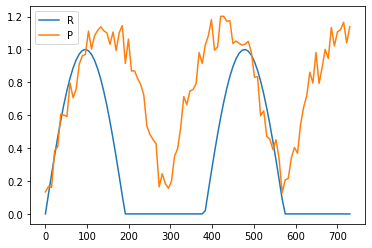

In [175]:
import matplotlib.pyplot as plt
print(np.pi)
def R(time):
    r = max(m.sin(time*6/365),0)
    return r
# photosynthesis
def P(time):
    first = m.sin(time*4/365)
    p = abs(first) + np.random.uniform()/4
    return p

exes = np.linspace(0,730,num = 100)

Rline = [R(t) for t in exes]
Pline = [P(t) for t in exes]

plt.plot(exes,Rline, label = "R")
plt.plot(exes,Pline,label = "P")
plt.legend()
plt.show()

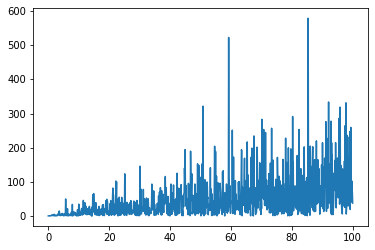

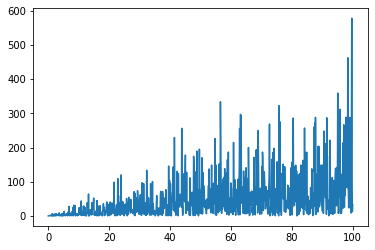

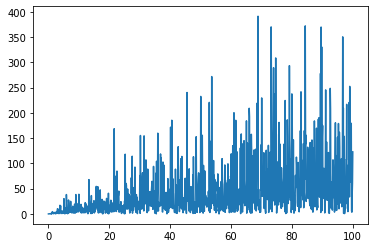

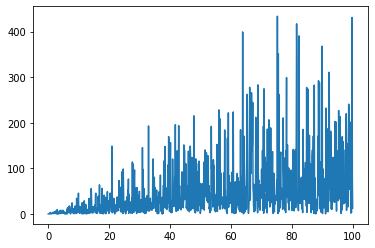

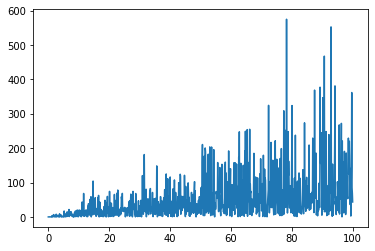

In [340]:
import matplotlib.pyplot as plt

for j in range(5):
    plt.figure()
    xValues = np.linspace(.000001,100,num = 1000)
    ys = np.zeros(len(xValues))
    for i in range(len(xValues)):
        ys[i] = np.random.exponential(xValues[i])

    plt.plot(xValues,ys)
    plt.show()